In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import ERFutils
import scipy.signal as signal
import cf_xarray as cfxr
from datetime import timedelta
import os

dask.config.set(**{'array.slicing.split_large_chunks': True})

### Import experiment to convolve, Green's Functions, and CMIP tas data

Load ssp585 as training data...
	Load 1pctCO2 run for convolution...
Convolving mean GF for Global Mean
Convolving mean GF Spatially
(0.2866, 0.2024, 0.0749)
(0.3323, 0.2403, -0.0137)

Short Stats...
[0.2866]
[0.2024]
[0.0749]

Long Stats...
[0.3323]
[0.2403]
[-0.0137]


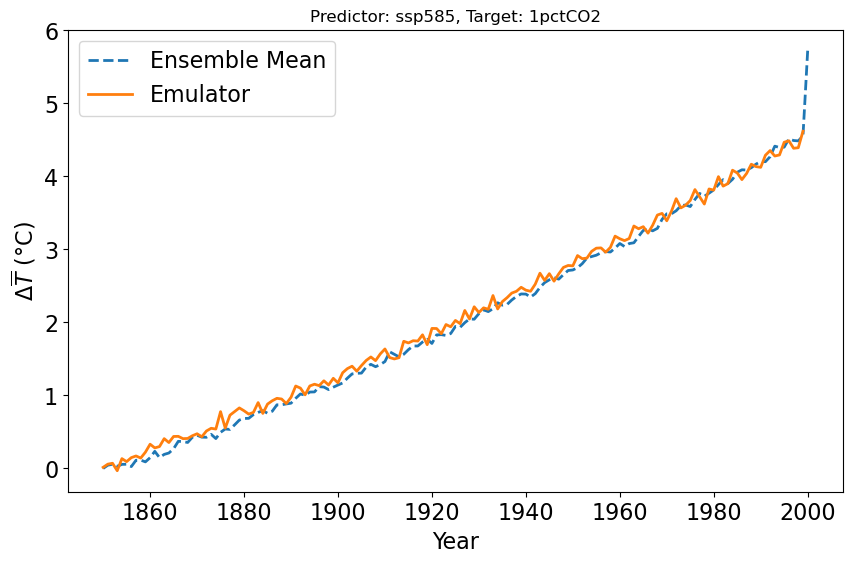

In [2]:
model_set = ERFutils.model_set
output_path = ERFutils.path_to_ERF_outputs

conv_id = ['1pctCO2']#,'ssp126','ssp245','ssp370','ssp585']
train_id = ['ssp585']

def add_hist_ssp(hist,ssp):
    # In the case of tas data
    if type(hist) == dict:
        ds = {}
        for m in hist.keys():
            ds[m] = xr.concat([hist[m],ssp[m]],dim = 'time')
    
    # In the case of ERF data
    else:
        ssp = ssp.assign_coords({'year':[int(i) for i in range(165,165+85)]})
        ds = xr.concat([hist,ssp],dim = 'year')
    return ds

loess = False
save = False

for train in train_id:
    print(f'Load {train} as training data...')
    
    # Import Green's Functions
    if loess:
        G_ds_path = f'{output_path}GFs/G_loess_{train}_ERF_mean_ds.nc4'
        G_ds = xr.open_dataset(G_ds_path)['G[tas]']
    else:
        G_ds_path = f'{output_path}GFs/G_{train}_ERF_mean_ds.nc4'
        G_ds = xr.open_dataset(G_ds_path)['__xarray_dataarray_variable__']
        
    G_ds.name = 'G[tas]'
    G_ds = G_ds.rename({'year':'s'})
    
    RMSE_short, RMSE_long = [], []
    MAE_short, MAE_long = [], []
    bias_short, bias_long = [], []
    
    for conv in conv_id:
        print(f'\tLoad {conv} run for convolution...')

        # Import experimental ERF data
        ERF_path = f'{output_path}ERF/ERF_{conv}_all_ds.nc4'
        if 'ssp' in conv and 'ssp' not in train:
            ERF_path_hist = f'{output_path}ERF/ERF_historical_all_ds.nc4'
            ERF_ssp = xr.open_dataset(ERF_path)
            ERF_hist = xr.open_dataset(ERF_path_hist)
            
            ERF_ds = xr.concat([ERF_hist,ERF_ssp.assign_coords(year = range(165,250))],dim = 'year')
        
        else:
            ERF_ds = xr.open_dataset(ERF_path)

        # Import CMIP tas data
        tas_CMIP_path = f'{output_path}tas/tas_CMIP_{conv}_all_ds.nc4'

        # Import the file if it exists
        if os.path.isfile(tas_CMIP_path):
            tas_CMIP = xr.open_dataset(tas_CMIP_path) 
            
            if 'ssp' in conv and 'ssp' in train:
                tas_CMIP = tas_CMIP.sel(s = slice(165,250)).assign_coords(s = range(0,85))

        # Otherwise create it
        else:
            tas_piControl = ERFutils.import_regrid_tas_set(model_set, 'piControl')
            if 'ssp' in conv:
                tas_hist = ERFutils.import_regrid_tas_set(model_set, 'historical')
                tas_ssp = ERFutils.import_regrid_tas_set(model_set, conv)
                tas_exp = add_hist_ssp(tas_hist,tas_ssp)

            else:
                tas_exp = ERFutils.import_regrid_tas_set(model_set, conv)

            tas_CMIP = ERFutils.calc_tas_CMIP_set(tas_exp, tas_piControl, model_set)
            tas_CMIP = tas_CMIP.as_numpy()
            tas_CMIP.to_netcdf(f'{output_path}tas/tas_CMIP_{conv}_all_ds.nc4')

        # Convolve
        conv_mean_ds = ERFutils.convolve_exp_meanGF(G_ds, ERF_ds, train, conv_mean = True)
        conv_ds = ERFutils.convolve_exp_meanGF(G_ds, ERF_ds, train, conv_mean = False)
        
        if save:
            conv_mean_ds.to_netcdf(f'{output_path}Global Mean Results/res_conv_global_{train}_{conv}_all_ds.nc4')
            conv_ds.to_netcdf(f'{output_path}Spatial Results/res_conv_spatial_{train}_{conv}_all_ds.nc4')    

        if 'ssp' in conv and 'ssp' not in train:
            start_yr1, plot_yr1, end_yr1 = 2040, 2050, 2060
            start_yr2, plot_yr2, end_yr2 = 2080, 2090, 2100
        elif 'ssp' in conv:
            start_yr1, plot_yr1, end_yr1 = 1875, 1885, 1895
            start_yr2, plot_yr2, end_yr2 = 1915, 1925, 1935
        elif 'hist' in conv:
            start_yr, plot_yr, end_yr = 1850, 1975, 2015
        else: # 1pctCO2
            start_yr1, plot_yr1, end_yr1 = 1940, 1950, 1960
            start_yr2, plot_yr2, end_yr2 = 1980, 1990, 2000
        
        # Make plots for analysis
        model_color = ERFutils.model_color
        type_color = ERFutils.type_color
        #ERFutils.plot_ERF_profile(ERF_ds, conv, model_color, save_fig = False)
        ERFutils.plot_conv_meanGF(train, conv, conv_mean_ds, tas_CMIP, save_fig = False)
        #ERFutils.plot_dif_map_meanGF(conv_ds, tas_CMIP, train_id = train, plot_yr = plot_yr1, yr_dif = 10, conv_id = conv, save_fig = False)
        #ERFutils.plot_dif_map_meanGF(conv_ds, tas_CMIP, train_id = train, plot_yr = plot_yr2, yr_dif = 10, conv_id = conv, save_fig = False)
        
        MSE1, RMSE1, MAE1, bias1 = ERFutils.calc_error_metrics(tas_CMIP, conv_ds, start_yr1, end_yr1, mean_GF = False)
        RMSE_short.append(round(RMSE1,4))
        MAE_short.append(round(float(MAE1),4))
        bias_short.append(round(float(bias1),4))
        print(f'({round(RMSE1,4)}, {round(float(MAE1),4)}, {round(float(bias1),4)})')
        
        MSE2, RMSE2, MAE2, bias2 = ERFutils.calc_error_metrics(tas_CMIP, conv_ds, start_yr2, end_yr2, mean_GF = False)
        RMSE_long.append(round(RMSE2,4))
        MAE_long.append(round(float(MAE2),4))
        bias_long.append(round(float(bias2),4))
        print(f'({round(RMSE2,4)}, {round(float(MAE2),4)}, {round(float(bias2),4)})')
        
    print('\nShort Stats...')
    print(RMSE_short)
    print(MAE_short)
    print(bias_short)
    
    print('\nLong Stats...')
    print(RMSE_long)
    print(MAE_long)
    print(bias_long)